# Compare and evaluate the performance of different models

In [2]:
import json
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

## Load in the relevant files

Load in the relevant files for each region and calculate the relevant metrics. 

In [53]:
# load in the json files
def load_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

region_list = {
    'uk':'2.0',
    'singapore':'2.0',
    'costarica':'2.0',
    'thailand':'1.0',
    'anguilla':'1.0',
    'madagascar':'1.0'
}

region_df = {}
ind = region_list[r].split('.', 1)[0]
if r == 'uk': ind = ind + 1

# loop through the region_list
for r in list(region_list.keys()):
    macro = load_json(f'/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/{r}_resnet_v{region_list[r]}_macro-accuracy.json')
    micro = load_json(f'/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/{r}_resnet_v{region_list[r]}_micro-accuracy.json')
    taxon = load_json(f'/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/{r}_resnet_v{region_list[r]}_taxon-accuracy.json')
    conf = pd.read_csv(f'/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/{r}_resnet_v{region_list[r]}_confusion-data.csv')
    labels = load_json(f'/bask/homes/f/fspo1218/amber/data/gbif_{r}/0{ind}_{r}_data_numeric_labels.json')

    region_df[r] = {'macro':macro, 'micro':micro, 'taxon':taxon, 'confusion_matrix': conf, 'labels':labels}


In [54]:
def summarise_data(macro, micro, taxon):

    # get the Pytorch values
    pytorch_macro = macro['Pytorch']
    tflite_macro = macro['TFLite']
    pytorch_micro = micro['Pytorch']
    tflite_micro = micro['TFLite']


    # create a df with a column for pytorch and tflite, and rows for each value in the dict
    df = pd.DataFrame(columns=['Value', 'Model', 'Type'])
    for k in pytorch_macro.keys():
        df = pd.concat([df, pd.DataFrame([[pytorch_macro[k], "Pytorch", "Macro"]], columns=['Value', 'Model', 'Type'], index=[k])])
        df = pd.concat([df, pd.DataFrame([[tflite_macro[k], "TFLite", "Macro"]], columns=['Value', 'Model', 'Type'], index=[k])])
        df = pd.concat([df, pd.DataFrame([[pytorch_micro[re.sub('macro', 'micro', k)], "Pytorch", "Micro"]], columns=['Value', 'Model', 'Type'], index=[re.sub('macro', 'micro', k)])])
        df = pd.concat([df, pd.DataFrame([[tflite_micro[re.sub('macro', 'micro', k)], "TFLite", "Micro"]], columns=['Value', 'Model', 'Type'], index=[re.sub('macro', 'micro', k)])])


    # add a column for species, genus, family deepending on the index
    df['Taxon'] = df.index.str.split('_').str[1]
    df['Measure'] = df.index.str.split('_').str[2]
    return(df)

In [55]:
def bar_plot(df, save=False, col_name='Macro', region='Costa Rica', dark_theme=False):
    # Set seaborn style and context
    if dark_theme:
        sns.set_style('darkgrid')
        sns.set_context('paper', font_scale=1.2)
        bar_colors = ['orchid', 'lightskyblue']
        text_color = 'white'
    else:
        sns.set_style('whitegrid')
        sns.set_context('paper')
        bar_colors = ['dodgerblue', 'lightcoral']
        text_color = 'black'

    df['Measure'] = df['Measure'].str.replace('top', 'Top ')
    df['Taxon'] = df['Taxon'].str.capitalize()

    # Plot results facet by taxon, and model
    g = sns.catplot(x='Taxon', y='Value', hue='Model', col='Measure',
                    data=df.loc[df['Type']==col_name, ],
                    kind='bar', height=4, aspect=0.7, palette=bar_colors)

    # Add values to top of bars
    for ax in g.axes.flat:
        for p in ax.patches:
            if p.get_x() + p.get_width()/2 in [-0.2, 0.8, 1.8]:
                ax.text(p.get_x() + p.get_width()/4., p.get_height(),
                        '%.2f' % p.get_height(),
                        fontsize=8, color=bar_colors[0], ha='left', va='bottom',
                        rotation=45, fontweight='bold')
            else:
                ax.text(p.get_x() + p.get_width()/4., p.get_height(),
                        '%.2f' % p.get_height(),
                        fontsize=8, color=bar_colors[1], ha='left', va='bottom',
                        rotation=45, fontweight='bold')

    g.set_xticklabels(rotation=-45)
    g.set_titles('{col_name}', color=text_color, y=1.1)
    g.set_axis_labels('', f'{col_name} Accuracy', color=text_color)
    g.tick_params(axis='both', colors=text_color)

    # suptitle
    g.fig.suptitle(f'{region} Model Performance', fontsize=14, y=1.1, color=text_color)
    g.fig.subplots_adjust(top=0.8)

    # set the legend title color
    g._legend.get_title().set_color(text_color)
    g._legend.get_title().set_size(10)

    # set the legend label colors
    for text in g._legend.get_texts():
        text.set_color(text_color)
        text.set_size(8)

    # set the figure size
    g.fig.set_size_inches(10, 3)

    if save:
        g.savefig('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/accuracy/' + region + '_' + col_name + '_new.png',
                  dpi=300, bbox_inches='tight', transparent=True)
    else:
        plt.show()

    return None


In [56]:
for r in list(region_df.keys()):
    print('Running for ' + r)
    cr_df = summarise_data(region_df[r]['macro'], region_df[r]['micro'], region_df[r]['taxon'])
    cr_df['Region'] = r
    #bar_plot(cr_df, save=True, dark_theme=True)
    #bar_plot(cr_df, col_name='Micro', save=True, dark_theme=True)
    region_df[r].update({'results':cr_df})

Running for uk
Running for singapore
Running for costarica
Running for thailand
Running for anguilla
Running for madagascar


In [57]:
master_df = pd.concat([region_df[r]['results'] for r in list(region_df.keys())])

master_df.to_csv('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/accuracy/master_df.csv')

master_df.head()

Value    Model   Type    Taxon Measure Region
macro_species_top1  59.71  Pytorch  Macro  species    top1     uk
macro_species_top1  59.78   TFLite  Macro  species    top1     uk
micro_species_top1  85.43  Pytorch  Micro  species    top1     uk
micro_species_top1  85.51   TFLite  Micro  species    top1     uk
macro_species_top3  72.56  Pytorch  Macro  species    top3     uk

## Plot and save the model accuracies

In [58]:
def add_values_to_bars(ax):
    for bar in ax.patches:
        ax.annotate(
            f'{bar.get_height():.2f}',
            (bar.get_x() + bar.get_width() / 2, bar.get_height() - 5),
            ha='center',
            va='top',
            xytext=(0, 6),
            textcoords='offset points',
            rotation=90,
            size=10,
            color='white'#bar.get_facecolor()
        )

In [59]:
# Filter the DataFrame for Measure = 'Top 1' and Type = 'Macro'
filtered_df = master_df[(master_df['Measure'] == 'top1') & (master_df['Type'] == 'Micro')]

# Separate the data into two DataFrames based on the Model
pytorch_df = filtered_df[filtered_df['Model'] == 'Pytorch']
tflite_df = filtered_df[filtered_df['Model'] == 'TFLite']

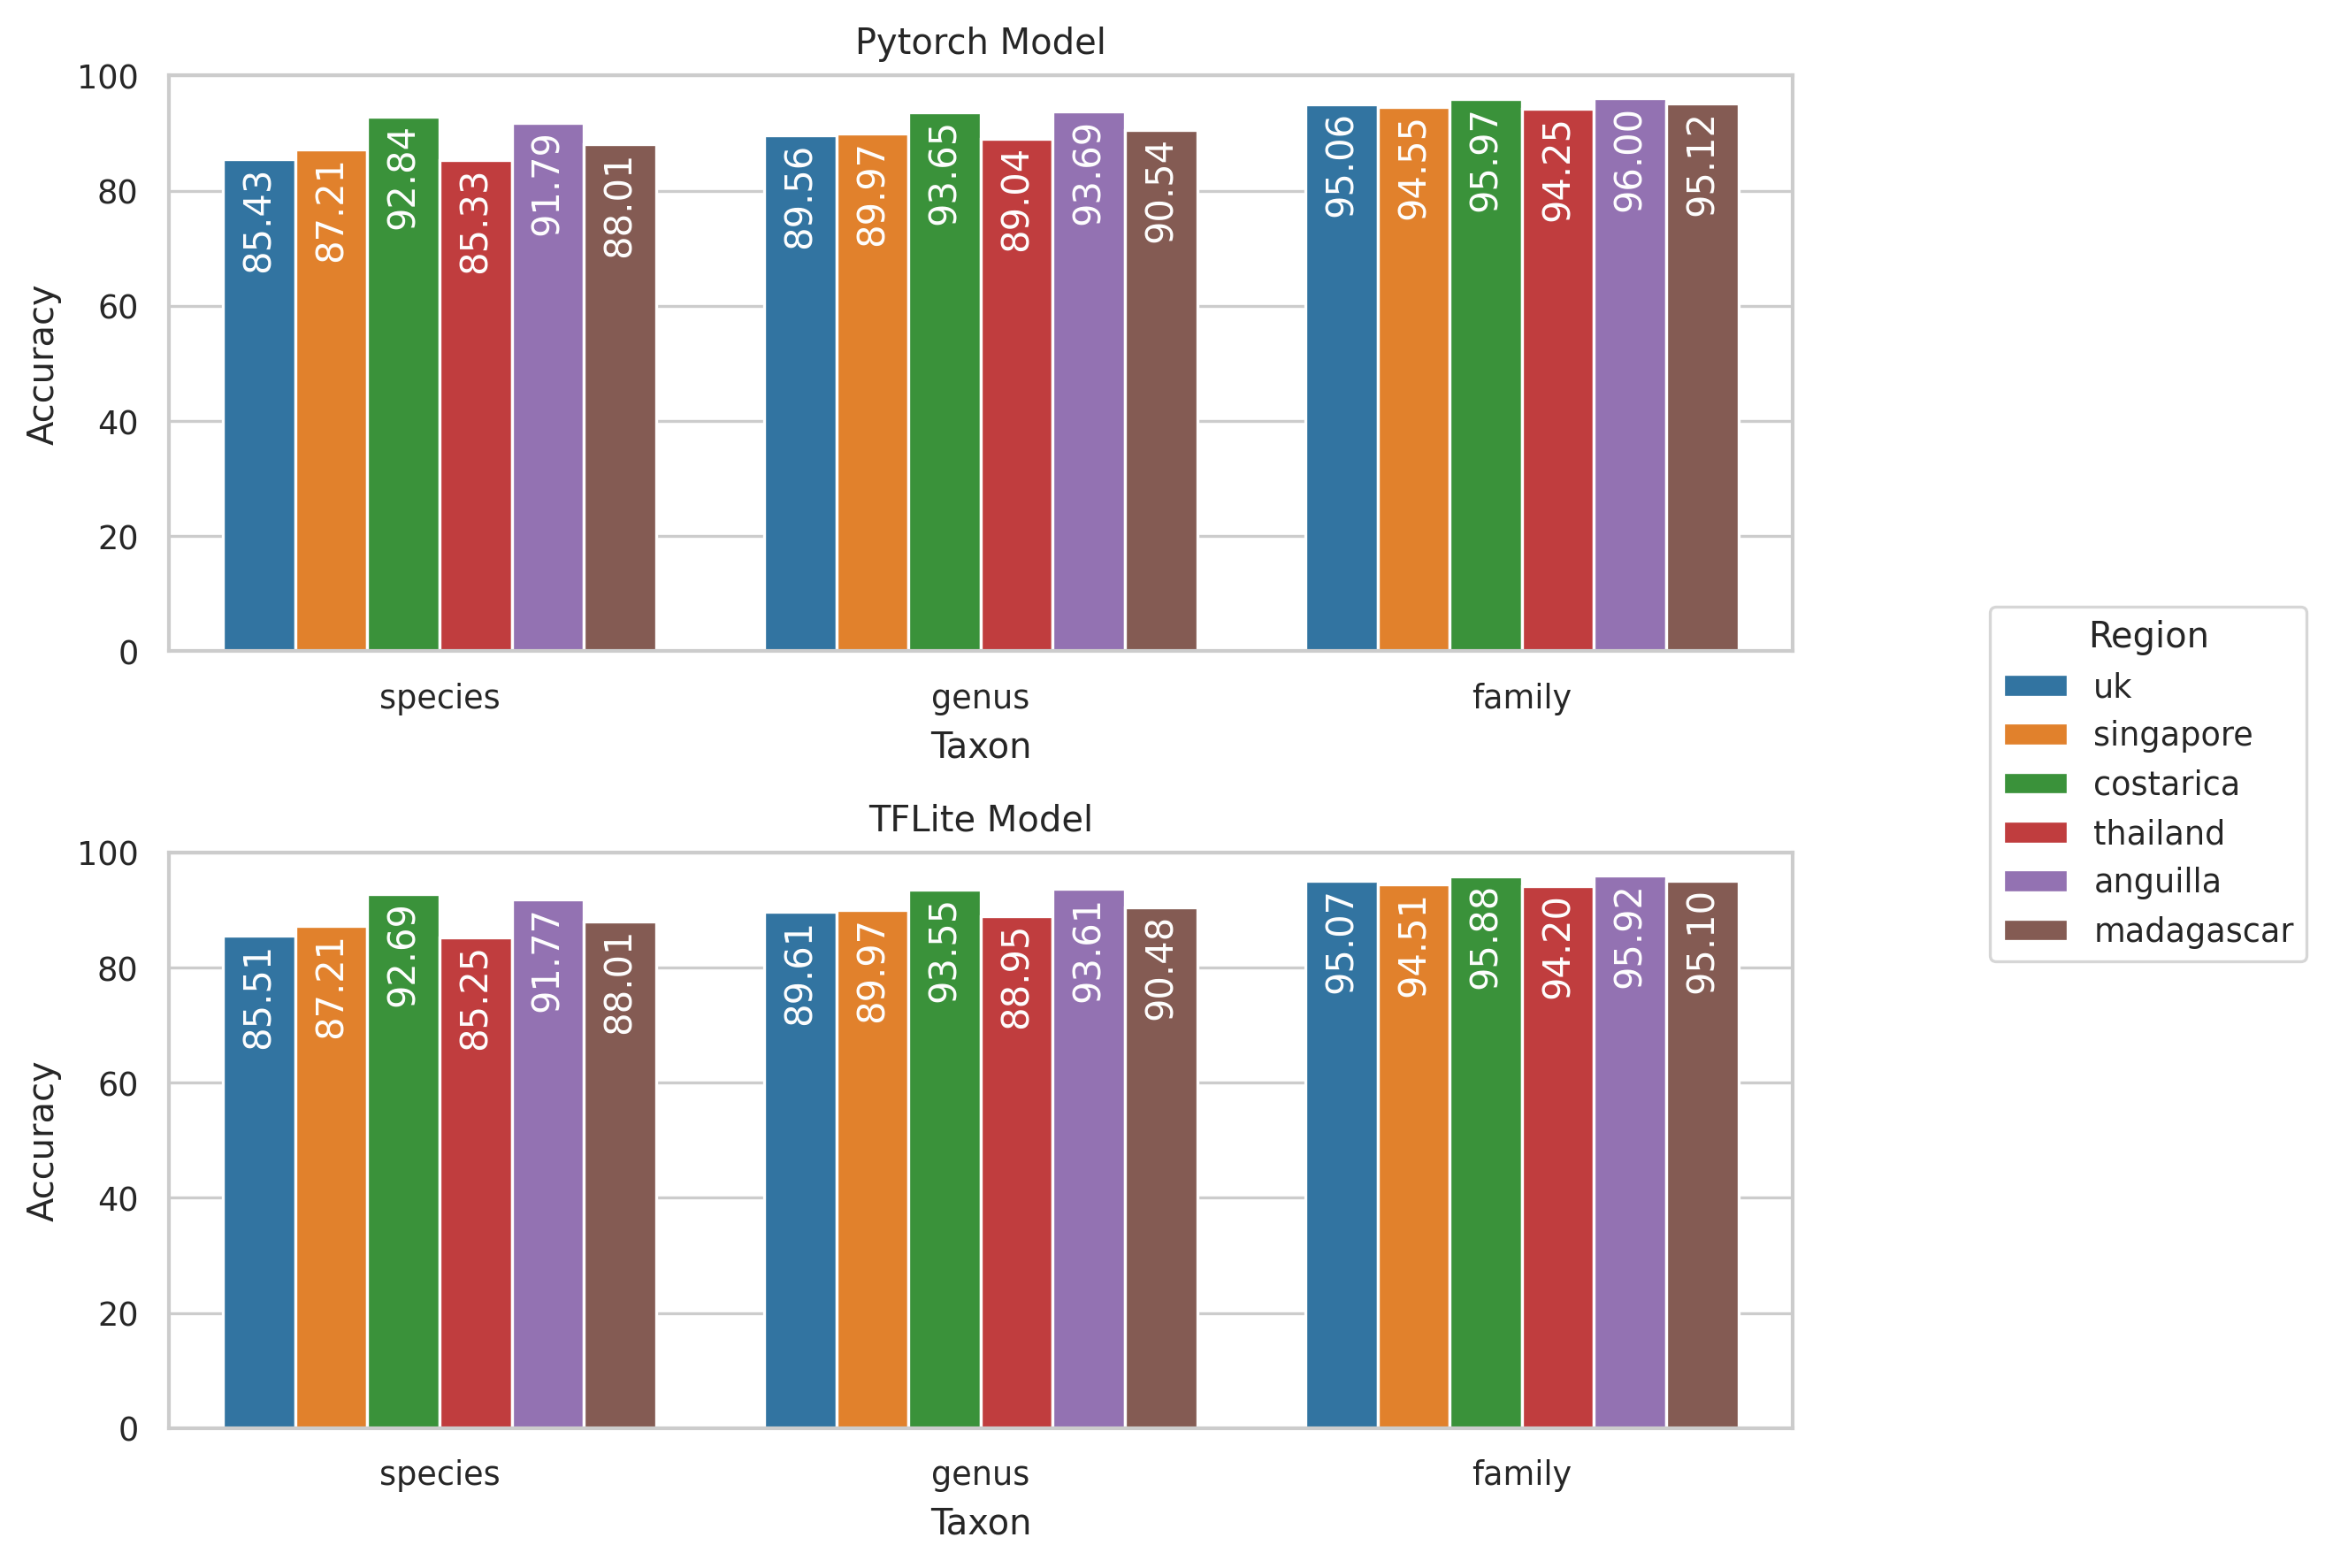

In [60]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=False, sharey=True, dpi=300)

# Plot for Pytorch
sns.barplot(ax=axes[0], data=pytorch_df, x='Taxon', y='Value', hue='Region', dodge=True)
axes[0].set_title('Pytorch Model')
axes[0].set_xlabel('Taxon')
axes[0].set_ylabel('Accuracy')
add_values_to_bars(axes[0])
axes[0].get_legend().remove()

# Plot for TFLite
sns.barplot(ax=axes[1], data=tflite_df, x='Taxon', y='Value', hue='Region', dodge=True)
axes[1].set_title('TFLite Model')
axes[1].set_xlabel('Taxon')
axes[1].set_ylabel('Accuracy')
add_values_to_bars(axes[1])
axes[1].get_legend().remove()
axes[1].set_ylim(0, 100)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Add legend outside the plot area
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title='Region')

plt.savefig('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/accuracy/micro_accuracy.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

# F1 Score

In [61]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

def calculate_metrics(df, ground_truth_col, prediction_col):
    # Get unique types in the ground truth column
    unique_types = df[ground_truth_col].unique()

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(df[ground_truth_col], df[prediction_col])

    # From confusion_matrix get TP, FP, TN, FN for each type
    # TP = np.diag(conf_matrix)
    # FP = conf_matrix.sum(axis=0) - TP
    # FN = conf_matrix.sum(axis=1) - TP
    # TN = conf_matrix.sum() - (TP + FP + FN)

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(df[ground_truth_col], df[prediction_col], average='weighted')
    recall = recall_score(df[ground_truth_col], df[prediction_col], average='weighted')
    f1 = f1_score(df[ground_truth_col], df[prediction_col], average='weighted')
    ba = balanced_accuracy_score(df[ground_truth_col], df[prediction_col])

    # Calculate the TPR
    # tpr = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Output results as a data frame
    results_df  = pd.DataFrame({'Taxon':[ground_truth_col],
                                'Model':[prediction_col],
                                # 'TP': [tpr], #'FP': FP, 'TN': TN, 'FN': FN,
                                'Precision': [precision],
                                'Recall': [recall],
                                'F1': [f1],
                                'Balanced Accuracy': [ba]})

    return results_df

In [62]:
# append them together
for r in list(region_df.keys()):
    cr_df = pd.concat([calculate_metrics(region_df[r]['confusion_matrix'], 'F_Truth', 'F_Tf_Prediction'),
                    calculate_metrics(region_df[r]['confusion_matrix'], 'G_Truth', 'G_Tf_Prediction'),
                    calculate_metrics(region_df[r]['confusion_matrix'], 'S_Truth', 'S_Tf_Prediction'),
                    calculate_metrics(region_df[r]['confusion_matrix'], 'F_Truth', 'F_Py_Prediction'),
                    calculate_metrics(region_df[r]['confusion_matrix'], 'G_Truth', 'G_Py_Prediction'),
                    calculate_metrics(region_df[r]['confusion_matrix'], 'S_Truth', 'S_Py_Prediction')])
    cr_df['Region'] = r
    region_df[r].update({'f1':cr_df})

/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-

In [63]:
master_df = pd.concat([region_df[r]['f1'] for r in list(region_df.keys())])
master_df['Model'] = master_df['Model'].str.split('_').str[1]
master_df['Taxon'] = master_df['Taxon'].str.split('_').str[0]

master_df = master_df.sort_values(by=['Taxon', 'Model'])
master_df.head()

Taxon Model  Precision    Recall        F1  Balanced Accuracy     Region
0     F    Py   0.950977  0.950647  0.950675           0.819558         uk
0     F    Py   0.945452  0.945502  0.945177           0.770736  singapore
0     F    Py   0.959572  0.959670  0.959526           0.854955  costarica
0     F    Py   0.942356  0.942476  0.942196           0.809802   thailand
0     F    Py   0.959799  0.960019  0.959823           0.849472   anguilla

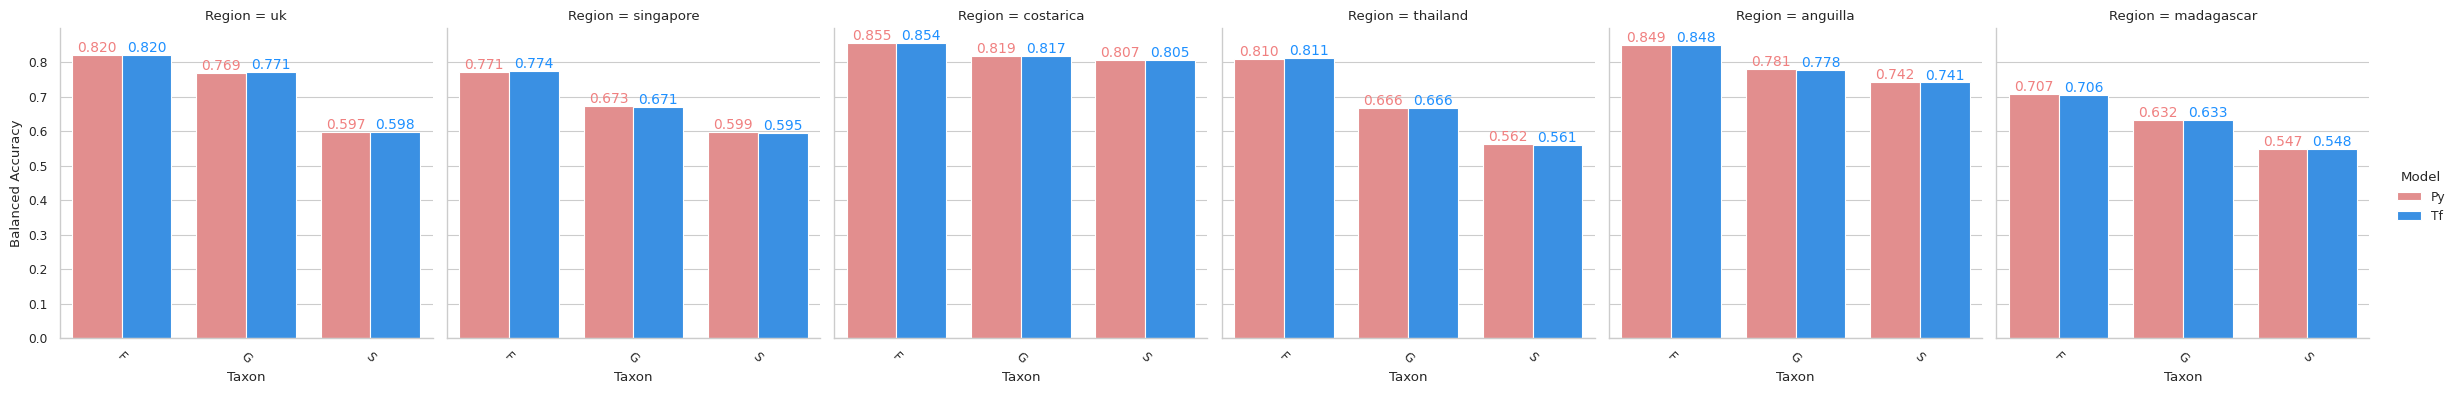

In [64]:
# Plot the results
sns.set_style('whitegrid')
sns.set_context('paper')

g = sns.catplot(x='Taxon', y='Balanced Accuracy', hue='Model', col='Region',
                data=master_df,
                kind='bar', height=4, aspect=1, palette=['lightcoral', 'dodgerblue'])

#add values to top of bars
for ax in g.axes.flat:
    for p in ax.patches:
        # if the value is in -0.2, 0.8, or 1.8 then light coral else dodger blue
        if p.get_x()+ p.get_width()/2 in [-0.2, 0.8, 1.8]:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.3f' % p.get_height(),
                    fontsize=10, color='lightcoral', ha='center', va='bottom')
        else:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.3f' % p.get_height(),
                    fontsize=10, color='dodgerblue', ha='center', va='bottom')

g.set_xticklabels(rotation=-45)
plt.show()
#plt.savefig('./outputs/plots/accuracy/f1_scores.png', dpi=300, bbox_inches='tight')

# Confusion Matrices

In [88]:
# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context('paper')

def create_cf(json_names, conf, str_head='F'):
    # create a confusion matrix for Truth and Tf_Prediction
    inp = str_head + '_Truth'
    inp2 = str_head + '_Tf_Prediction'
    confusion = pd.crosstab(conf[inp], conf[inp2], margins=True)

    # F=family, G=genus, S=species
    if str_head == 'F':
        names = json_names['family_list']
    elif str_head == 'G':
        names = json_names['genus_list']
    elif str_head == 'S':
        names = json_names['species_list']


    # convert the confusion index to the family names
    confusion.index = [names[x] for x in confusion.index[:-1]] + ['All']
    confusion.columns = [names[x] for x in confusion.columns[:-1]] + ['All']

    return(confusion)

def create_cf_matrix(confusion, spec='', save=False, spec2='', fs=(6.5, 8)):
    plt.figure(figsize=fs)

    gs = plt.GridSpec(2, 2, width_ratios=[1, 0.07], height_ratios=[0.07, 1], wspace=0.01, hspace=0.01)

    # Plot the heatmap with continuous values
    ax_heatmap = plt.subplot(gs[1, 0])
    ax_row_annotation = plt.subplot(gs[1, 1])
    ax_col_annotation = plt.subplot(gs[0, 0])

    conf2 = confusion.iloc[:-1, :-1]
    plt.title(spec + ' Confusion Matrix for ' + spec2 + 'Model')

    # plot the confusion matrix with annotation row for the 'All' column
    g = sns.heatmap(conf2, annot=True, cmap='Blues', cbar=False, ax=ax_heatmap, fmt='.0f', annot_kws={'size': 8})
    g.set_xlabel('Predicted')
    g.set_ylabel('Actual')
    g.set_xticklabels(g.get_xticklabels(), rotation=-45, ha='left')

    ra = sns.heatmap(pd.DataFrame({'feature2': confusion['All'][:-1]}), annot=True,fmt='.0f',
                cmap='Reds', annot_kws={'size': 8}, ax=ax_row_annotation,
                cbar=False, xticklabels=False, yticklabels=False)
    ra.set_xlabel('Total', rotation=-45, ha='left')


    ca = sns.heatmap(pd.DataFrame({'feature1': confusion.loc['All',][:-1]}).transpose(),
                cmap='Reds', annot_kws={'size': 8, 'rotation': 90},
                ax=ax_col_annotation, annot=True,fmt='.0f',
                cbar=False, xticklabels=False, yticklabels=False)
    ca.set_ylabel('Total')


    if save:
        plt.savefig('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/confusion/' + spec2 + '_confusion_' + spec + '.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

def create_cf_matrix2(confusion, spec='', save=False, spec2='', fs=(6.5, 8), dark_mode=False):
    if dark_mode:
        plt.figure(figsize=fs, facecolor='black')
        heatmap_color = 'Blues'
        annotation_color = 'Reds'
        text_color = 'white'
    else:
        plt.figure(figsize=fs)
        heatmap_color = 'Blues'
        annotation_color = 'Reds'
        text_color = 'black'

    gs = plt.GridSpec(2, 2, width_ratios=[1, 0.07], height_ratios=[0.07, 1], wspace=0.01, hspace=0.01)

    # Plot the heatmap with continuous values
    ax_heatmap = plt.subplot(gs[1, 0])
    ax_row_annotation = plt.subplot(gs[1, 1])
    ax_col_annotation = plt.subplot(gs[0, 0])

    conf2 = confusion.iloc[:-1, :-1]
    plt.title(spec + ' Confusion Matrix for ' + spec2 + 'Model', color=text_color)

    # Plot the confusion matrix with annotation row for the 'All' column
    g = sns.heatmap(conf2, annot=True, cmap=heatmap_color, cbar=False, ax=ax_heatmap, fmt='.0f',
                    annot_kws={'size': 8, 'color': text_color})
    g.set_xlabel('Predicted', color=text_color)
    g.set_ylabel('Actual', color=text_color)
    g.set_xticklabels(g.get_xticklabels(), rotation=-45, ha='left', color=text_color)
    g.set_yticklabels(g.get_yticklabels(), color=text_color)

    ra = sns.heatmap(pd.DataFrame({'feature2': confusion['All'][:-1]}), annot=True, fmt='.0f',
                    cmap=annotation_color, annot_kws={'size': 8, 'color': text_color}, ax=ax_row_annotation,
                    cbar=False, xticklabels=False, yticklabels=False)
    ra.set_xlabel('Total', rotation=-45, ha='left', color=text_color)

    ca = sns.heatmap(pd.DataFrame({'feature1': confusion.loc['All',][:-1]}).transpose(),
                    cmap=annotation_color, annot=True, fmt='.0f',
                    annot_kws={'size': 8, 'color': text_color, 'rotation': 90},
                    ax=ax_col_annotation, cbar=False, xticklabels=False, yticklabels=False)
    ca.set_ylabel('Total', color=text_color)

    if save:
        plt.savefig('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/confusion/' + spec2 + '_confusion_' + spec + '.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()


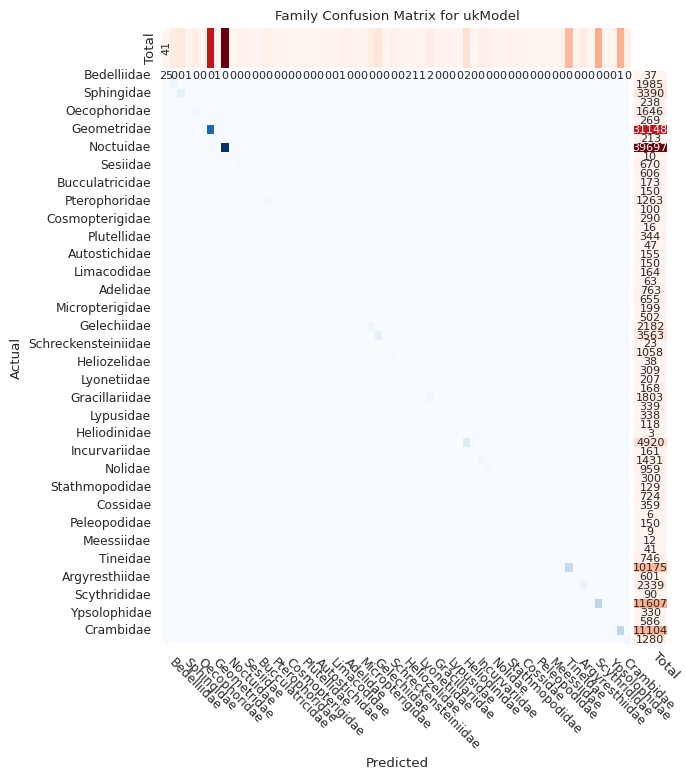

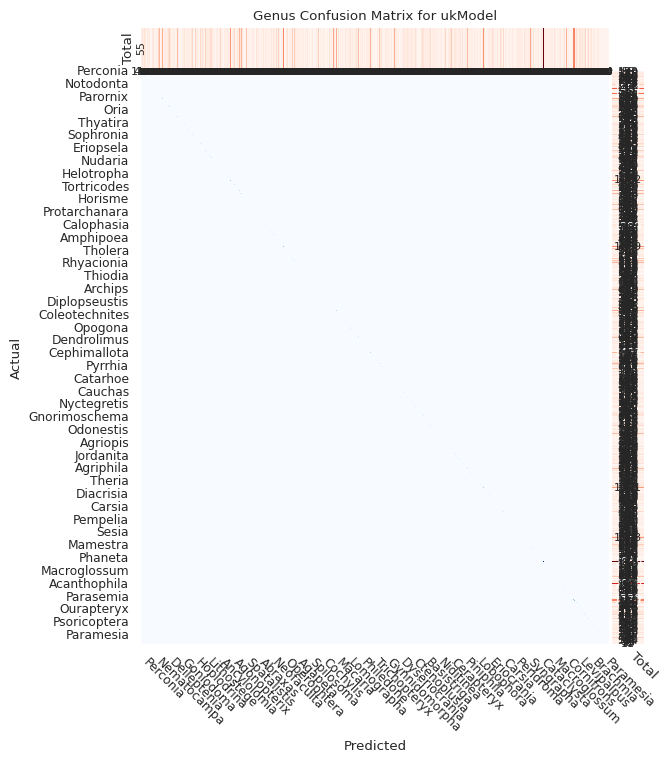

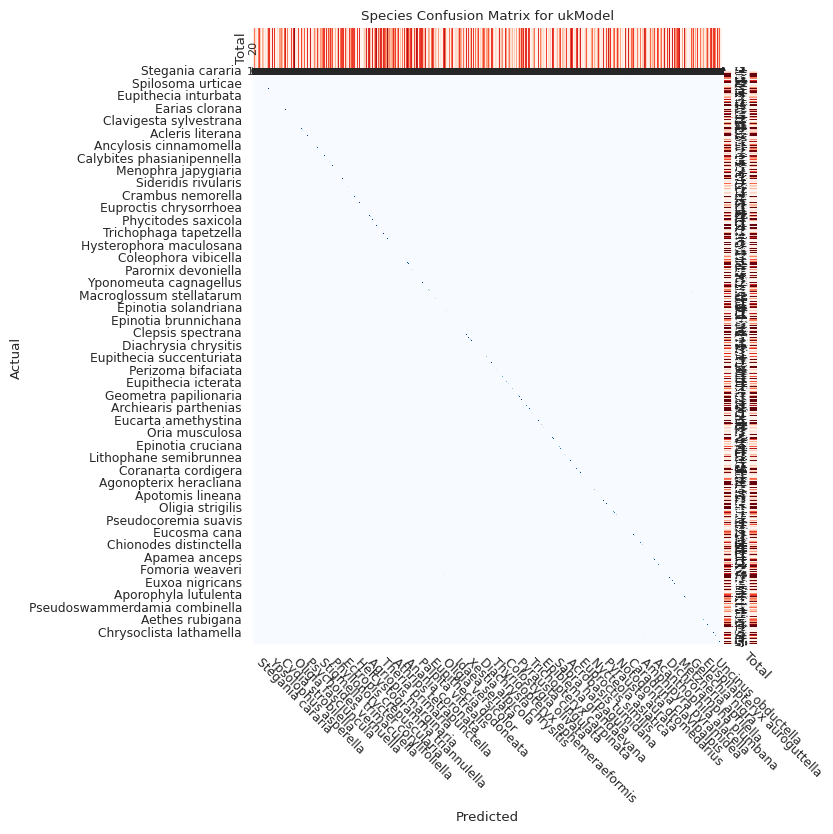

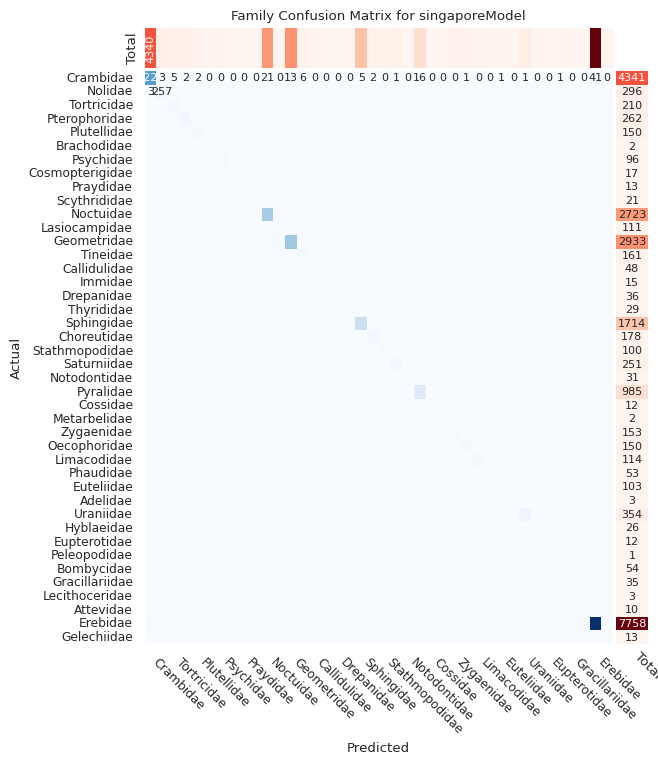

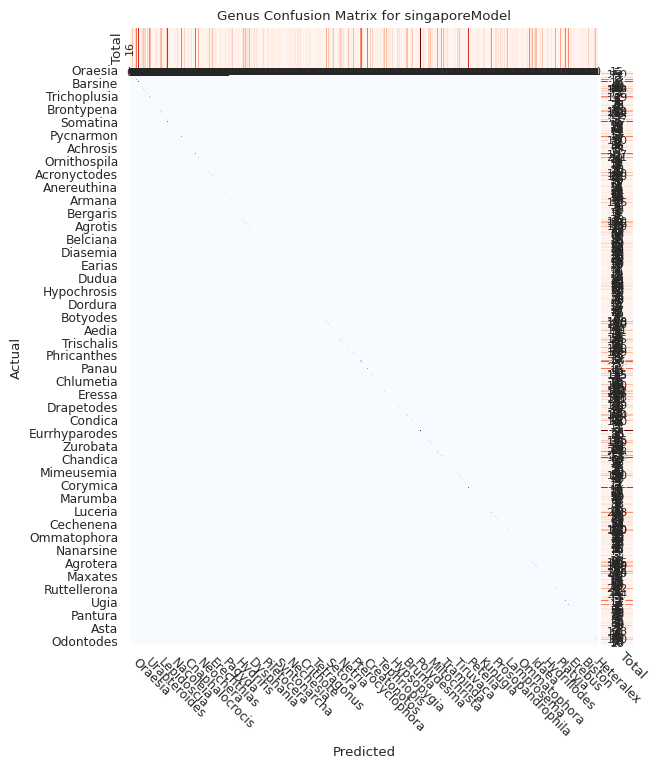

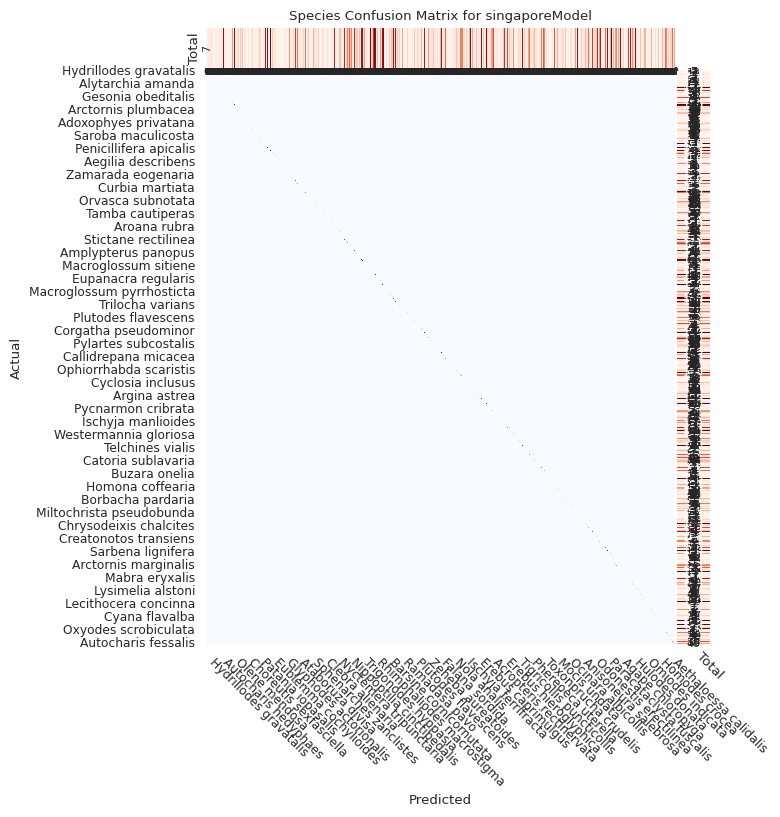

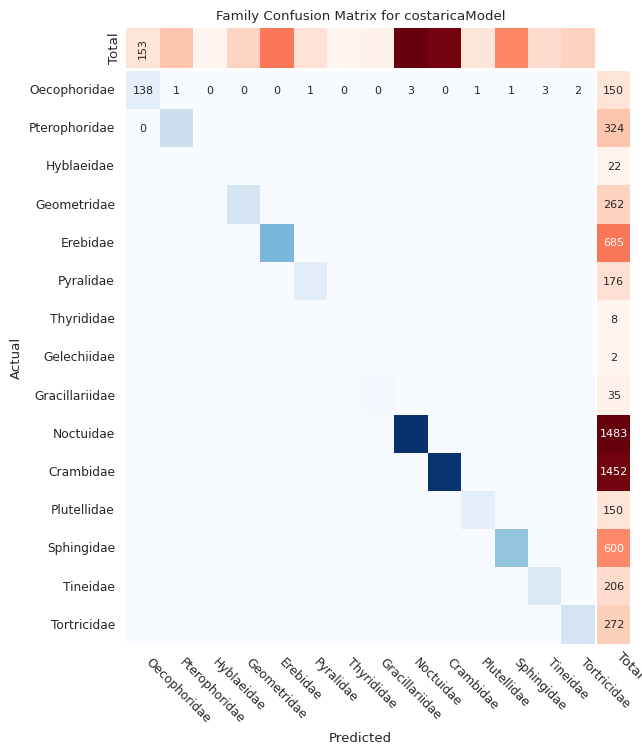

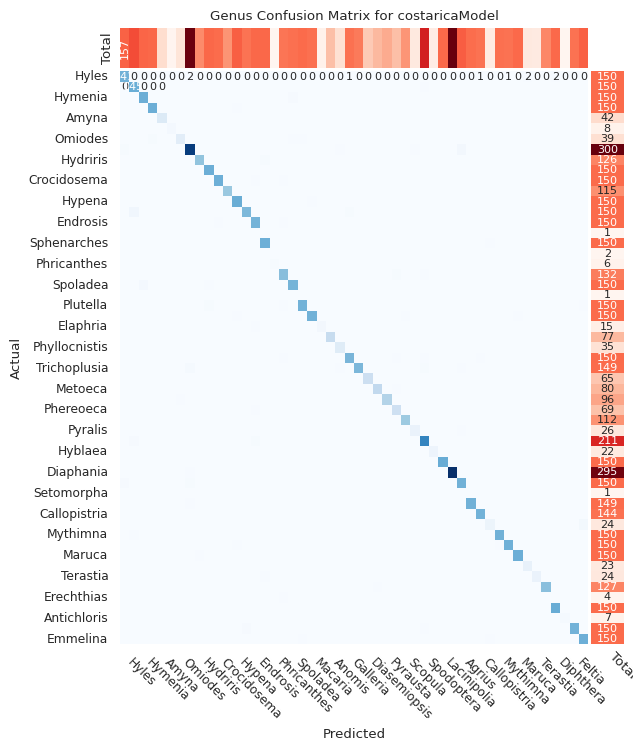

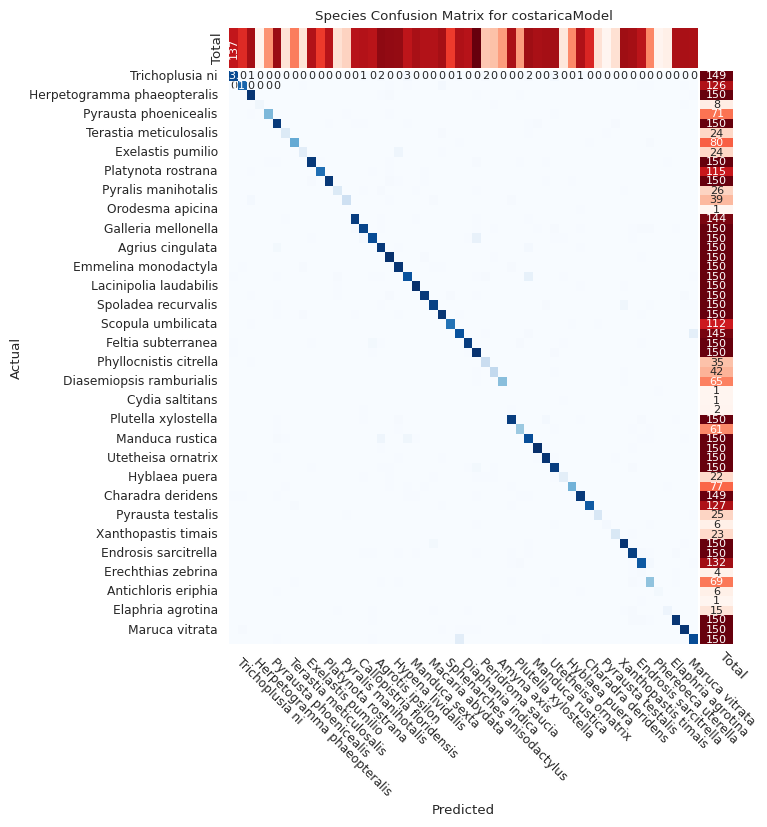

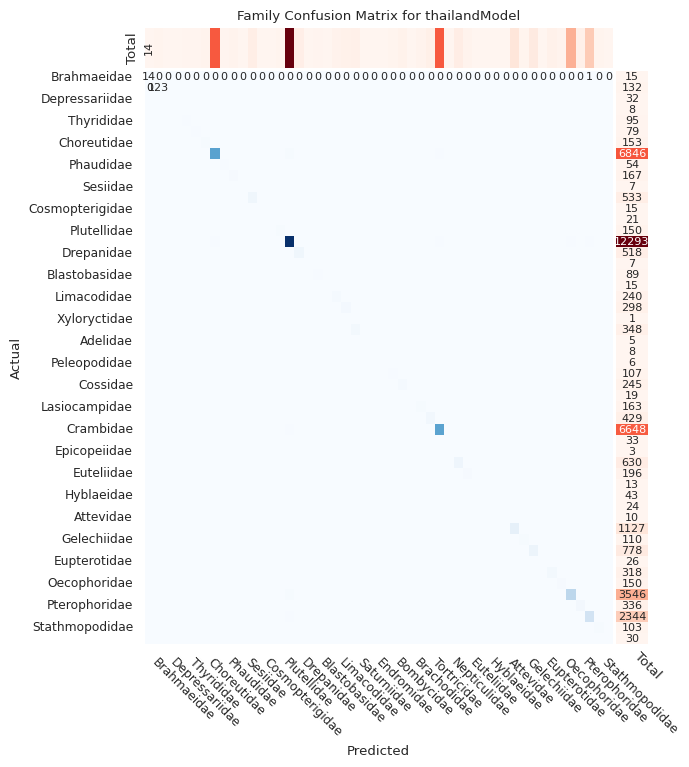

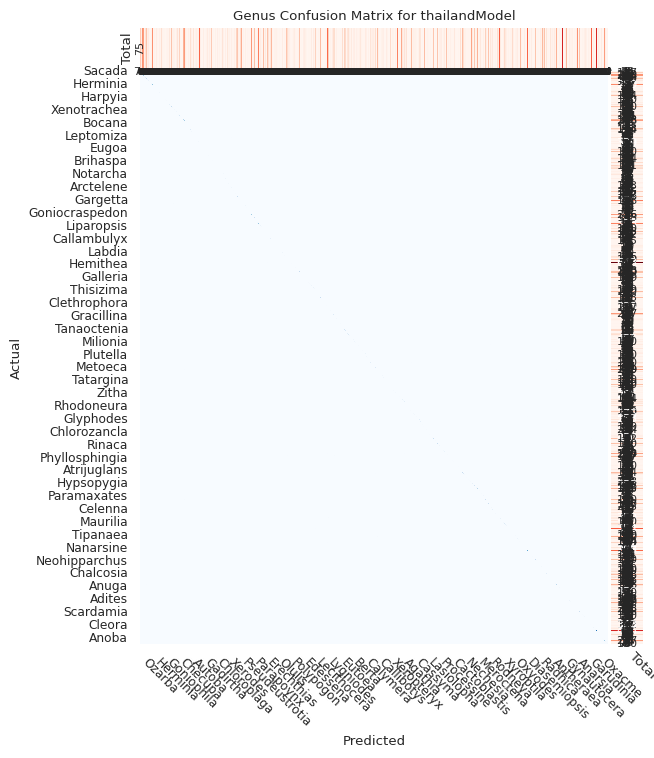

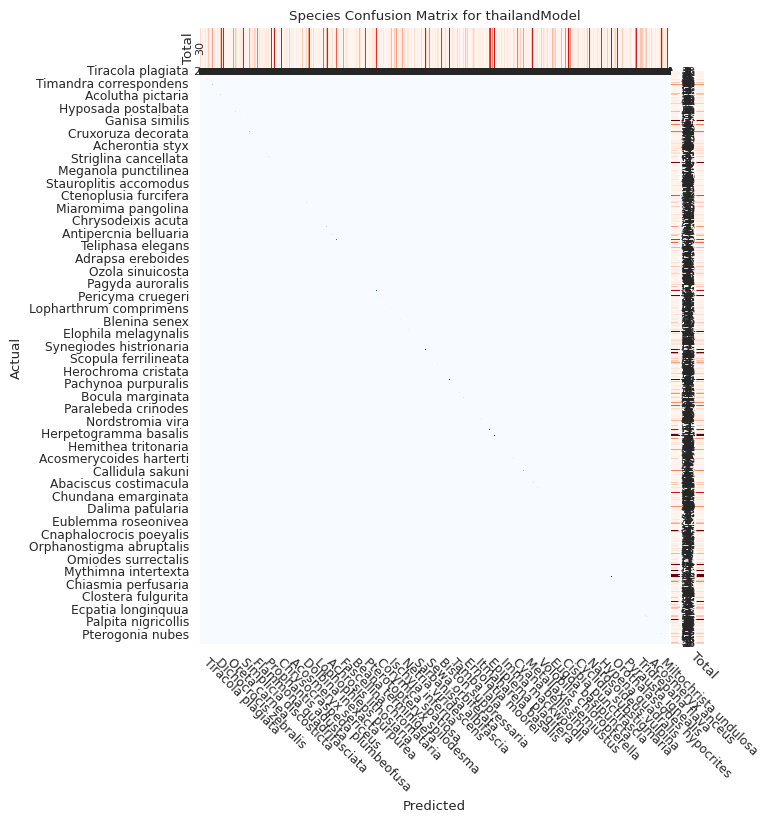

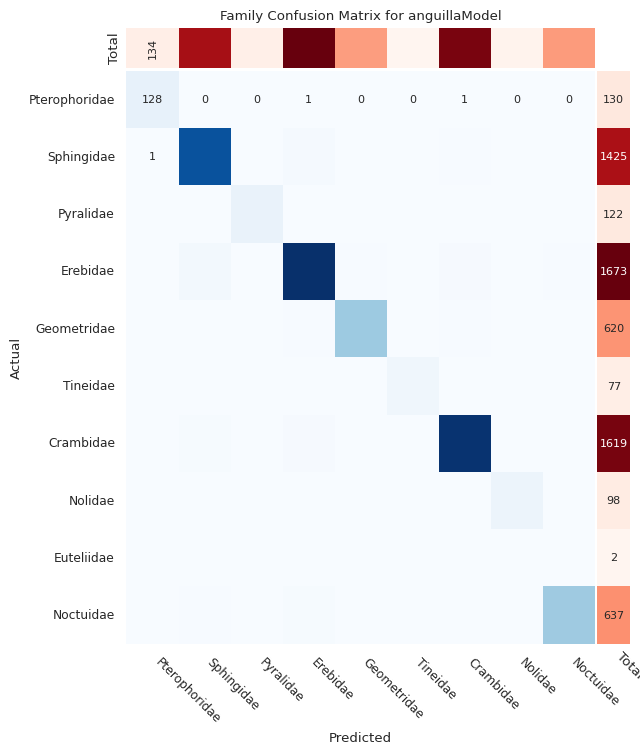

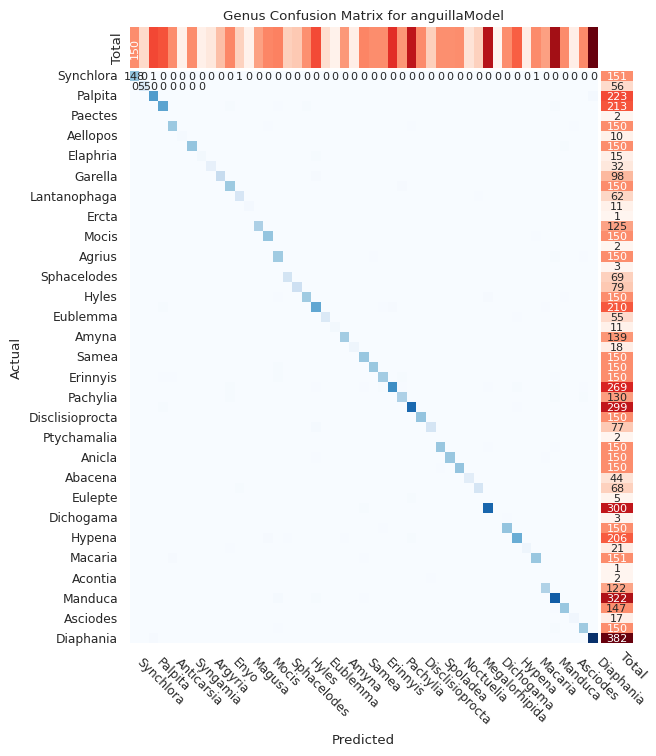

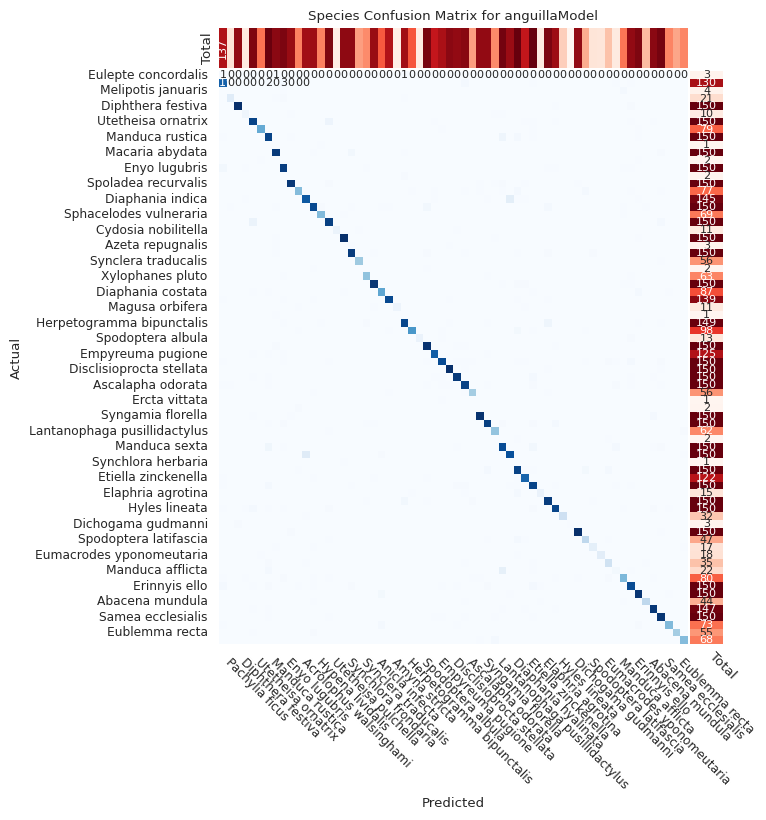

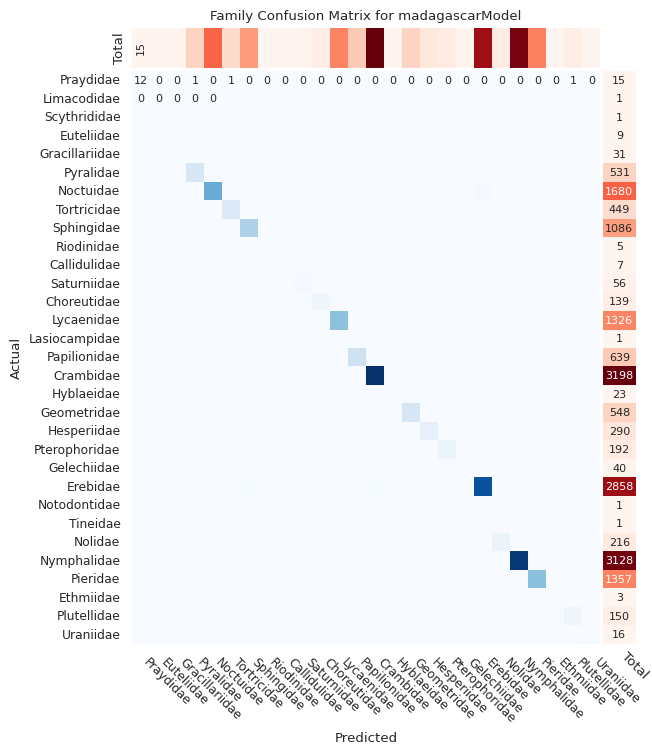

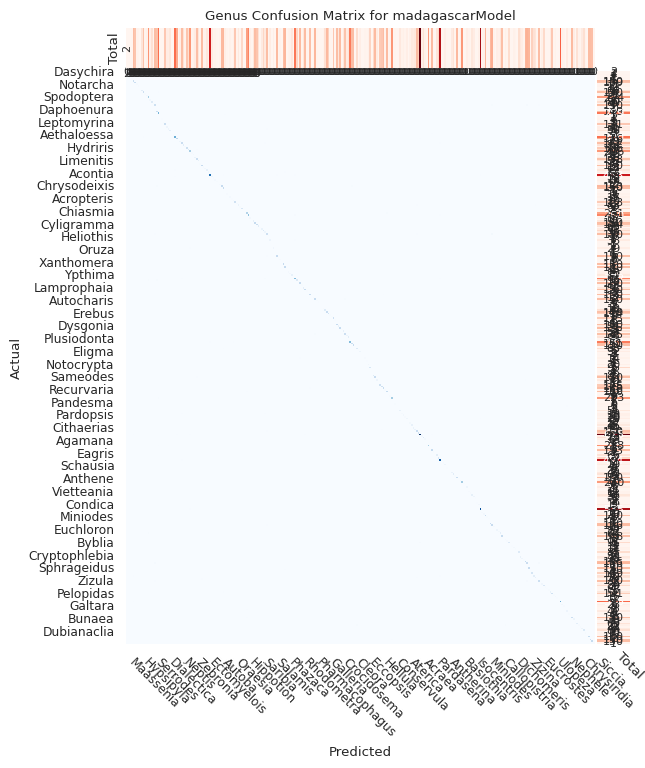

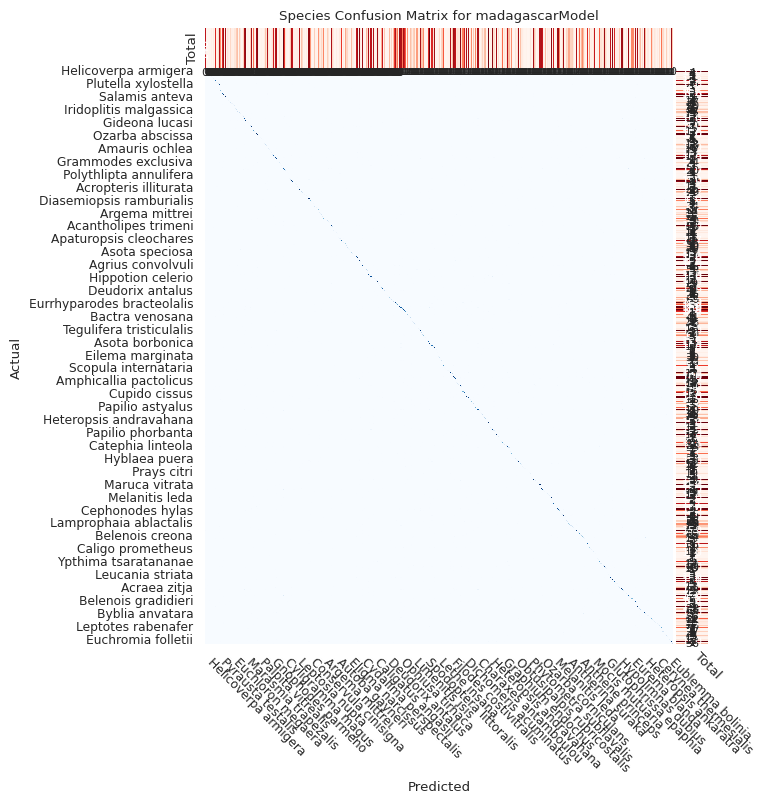

In [91]:
for r in list(region_df.keys()):
    json_names = region_df[r]['labels']
    conf = region_df[r]['confusion_matrix']

    fam_cf = create_cf(json_names, conf, str_head='F')
    create_cf_matrix(fam_cf, spec = "Family", spec2=r, save=True)

    gen_cf = create_cf(json_names, conf, str_head='G')
    create_cf_matrix(gen_cf, spec = "Genus", spec2=r, save=True)

    spec_cf = create_cf(json_names, conf, str_head='S')
    create_cf_matrix(spec_cf, spec = "Species", spec2=r, save=True)

    region_df[r].update({'family_confusion_matrix': fam_cf,
                         'genus_confusion_matrix': gen_cf,
                         'species_confusion_matrix': spec_cf})


# Taxon Accuracy

In [68]:
# Plot the accuracy for each species as a line chart with the test points as a bar chart behind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('paper')

def taxon_acc_plot(taxon_json, model='TFLite', taxon='species', region='Costa Rica', dark_mode=False):
    tax_accuracy = taxon_json[model][taxon]

    tax = []
    accuracy = []
    test_points = []
    for k, v in tax_accuracy.items():
        tax.append(k)
        accuracy.append(v[0])
        test_points.append(v[1])

    # Create a df with the species, accuracy and test points
    df = pd.DataFrame({'Taxon': tax, 'Accuracy': accuracy, 'Test Points': test_points})

    # Create a figure and axis
    if dark_mode:
        fig, ax1 = plt.subplots(figsize=(12, 3), facecolor='black')
        color1 = 'coral'
        color2 = 'dodgerblue'
        text_color = 'white'
    else:
        fig, ax1 = plt.subplots(figsize=(12, 3))
        color1 = 'tab:red'
        color2 = 'tab:blue'
        text_color = 'black'

    # Plot test points on the left y-axis (bar chart)
    ax1.set_xlabel(taxon.capitalize(), color=text_color)
    ax1.set_ylabel('Test Points', color=color1)
    ax1.bar(df['Taxon'], df['Test Points'], color=color1, alpha=0.5)
    ax1.tick_params(axis='y', labelcolor=color1)

    # Rotate the x labels
    ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)

    # Create a second y-axis for accuracy (line chart)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', color=color2)
    ax2.plot(df['Taxon'].values, df['Accuracy'].values, color=color2, marker='o')
    ax2.tick_params(axis='y', labelcolor=color2)

    # Adjust layout
    plt.title('Accuracy by ' + taxon.capitalize() + ' for ' + region + ' Model', color=text_color)

    return fig, ax1, ax2


Plotting for uk...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


Plotting for singapore...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


Plotting for costarica...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


Plotting for thailand...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


Plotting for anguilla...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


Plotting for madagascar...


/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)
/tmp/ipykernel_3752711/1278888461.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left', color=text_color)


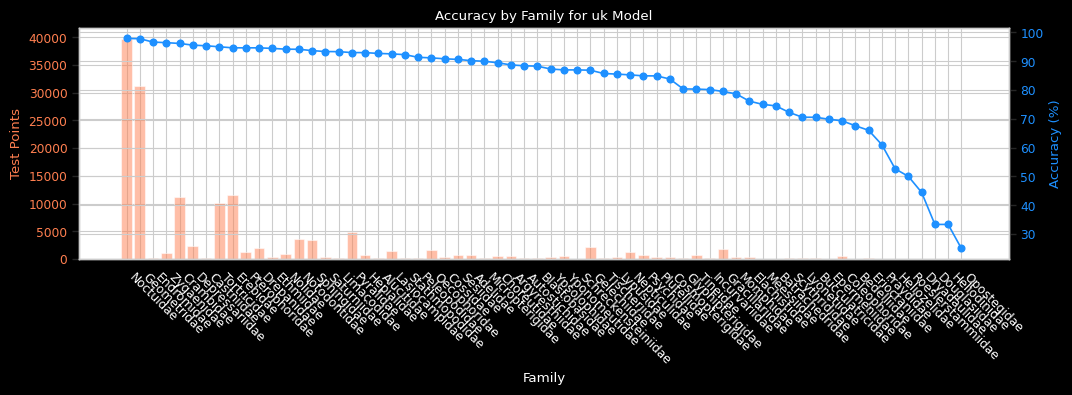

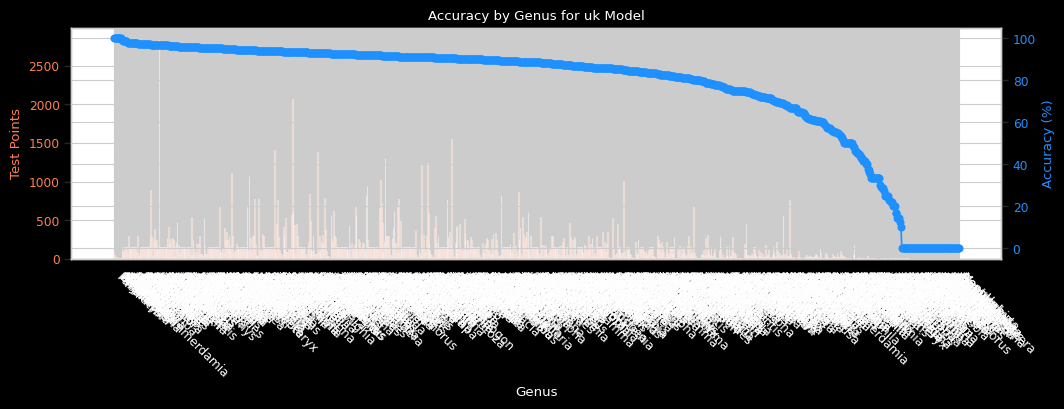

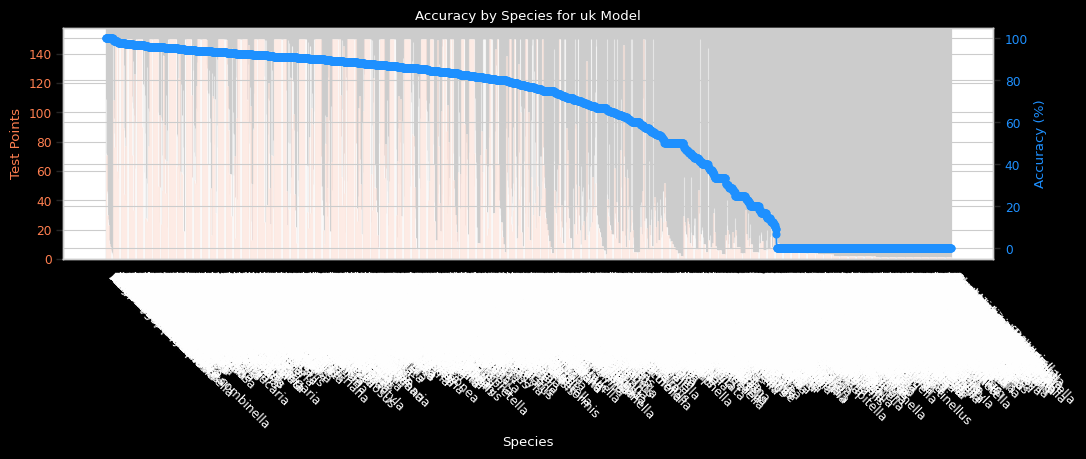

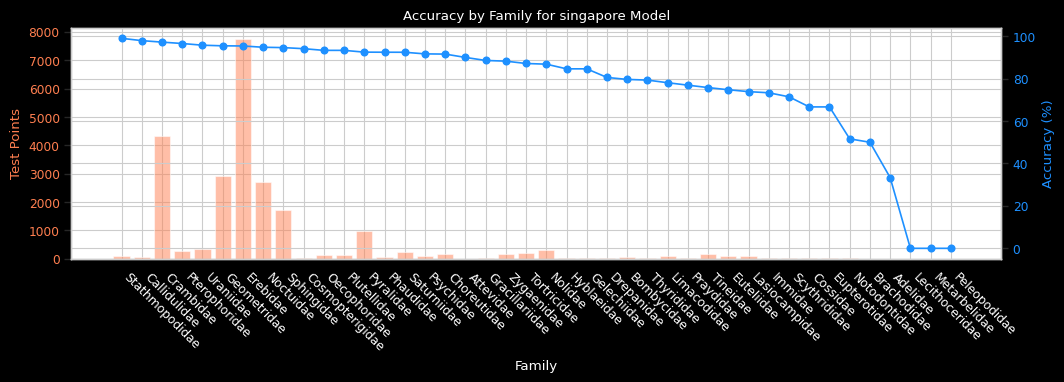

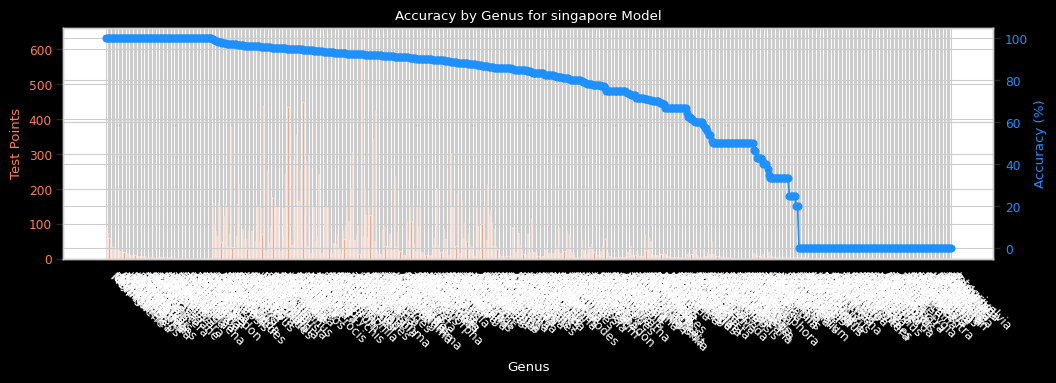

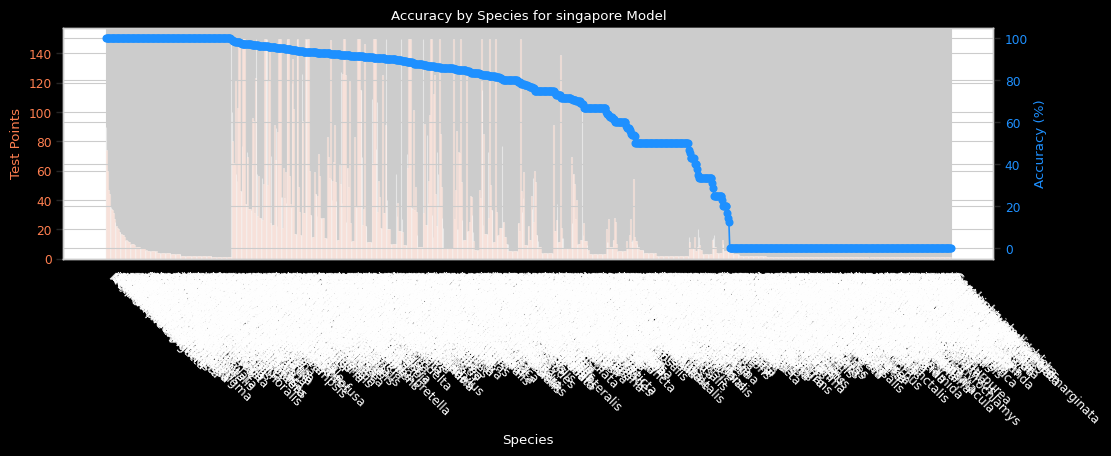

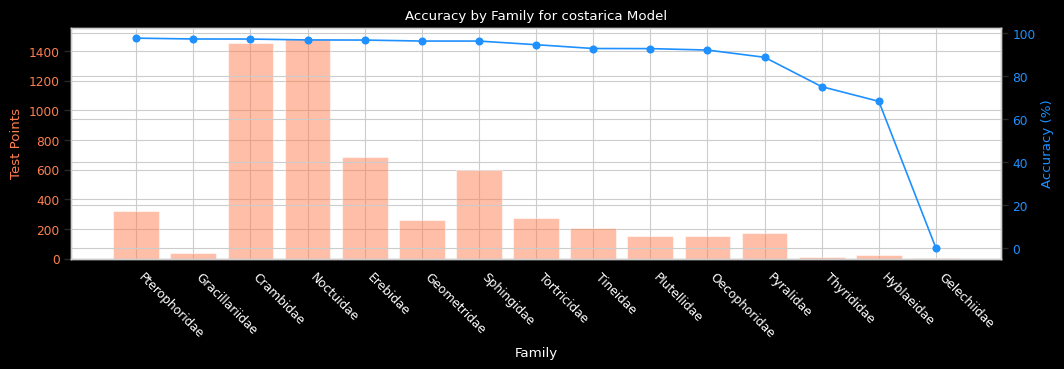

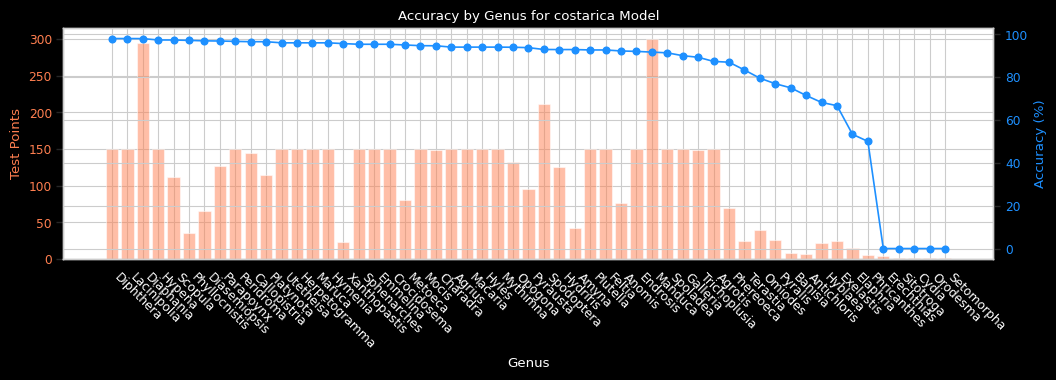

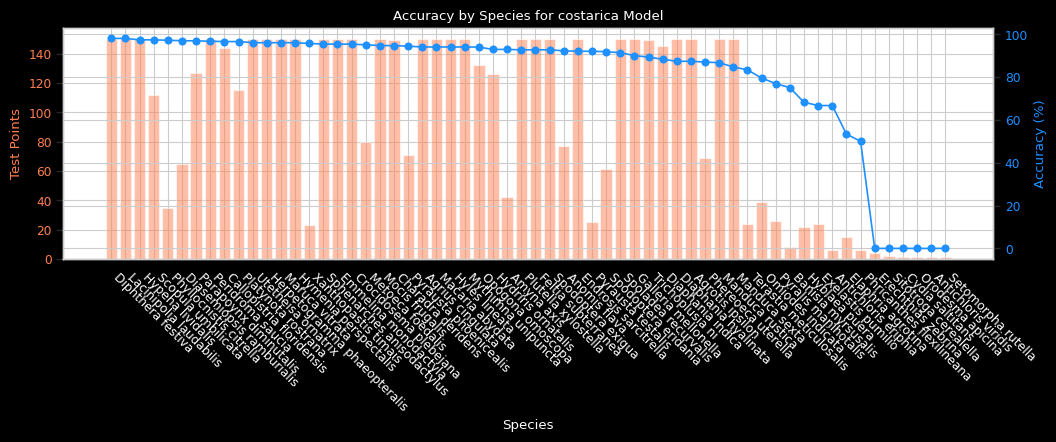

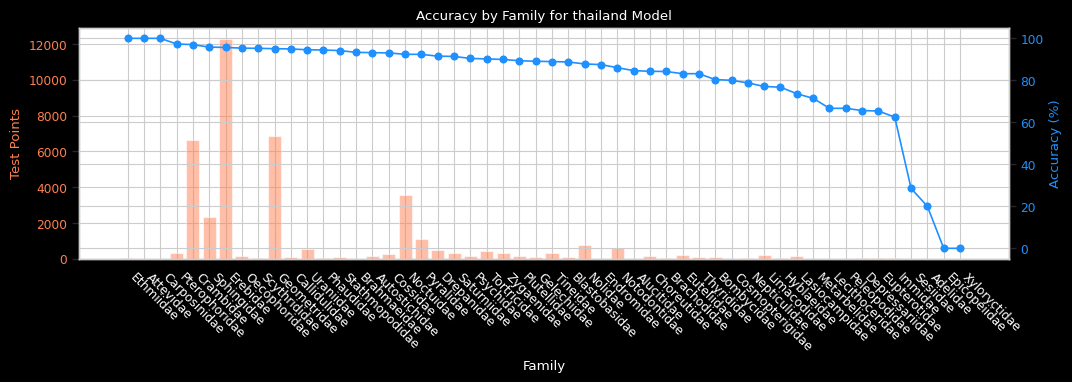

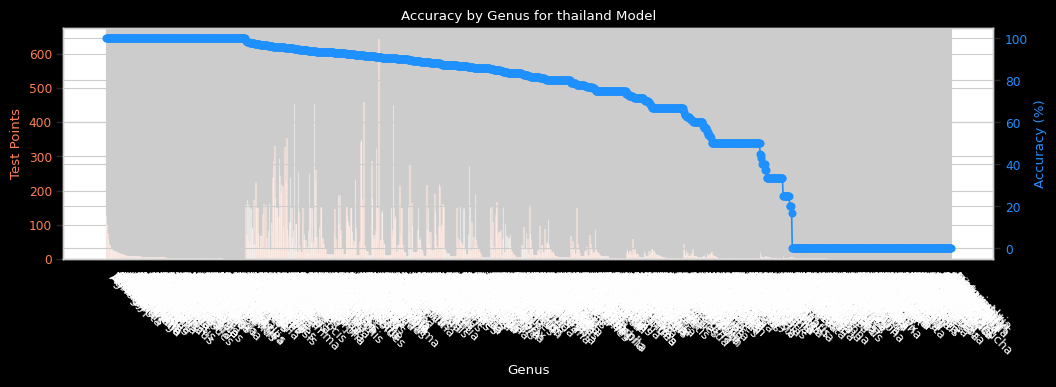

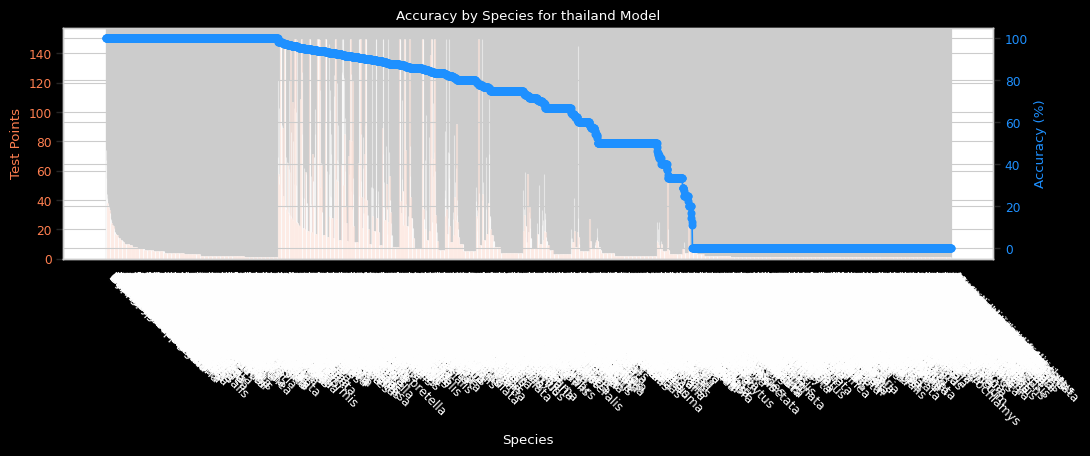

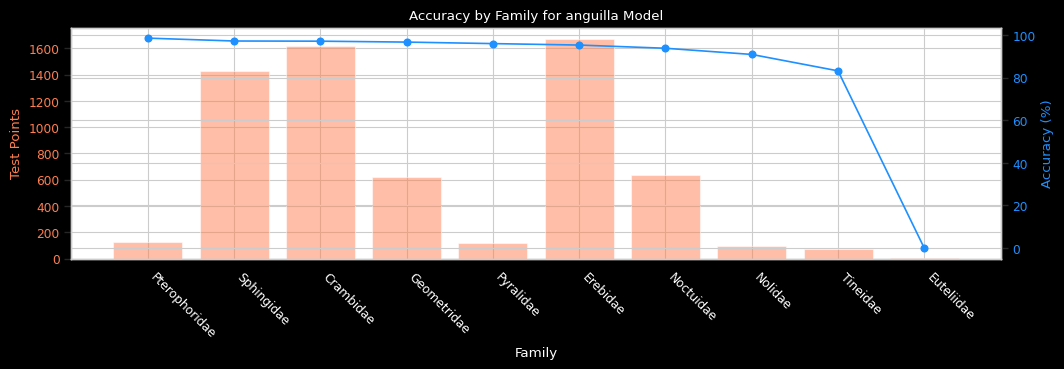

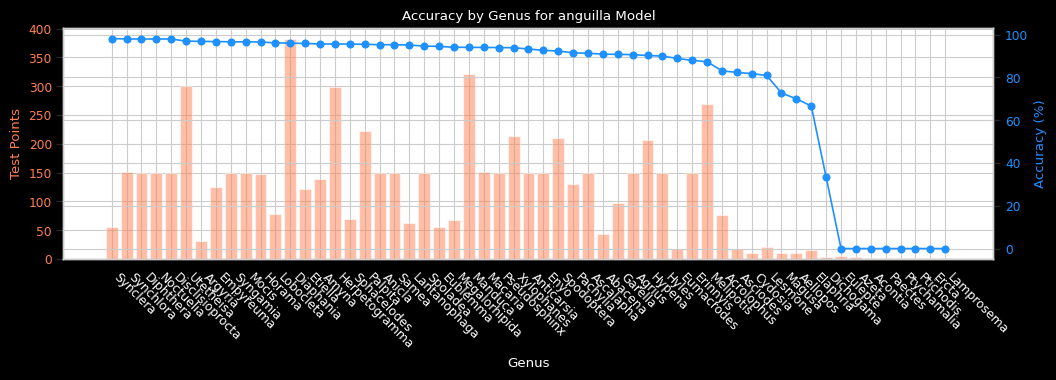

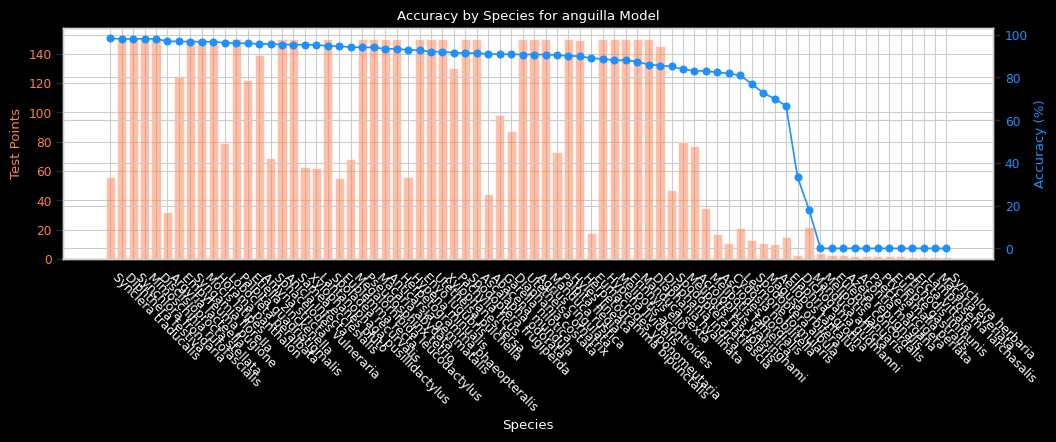

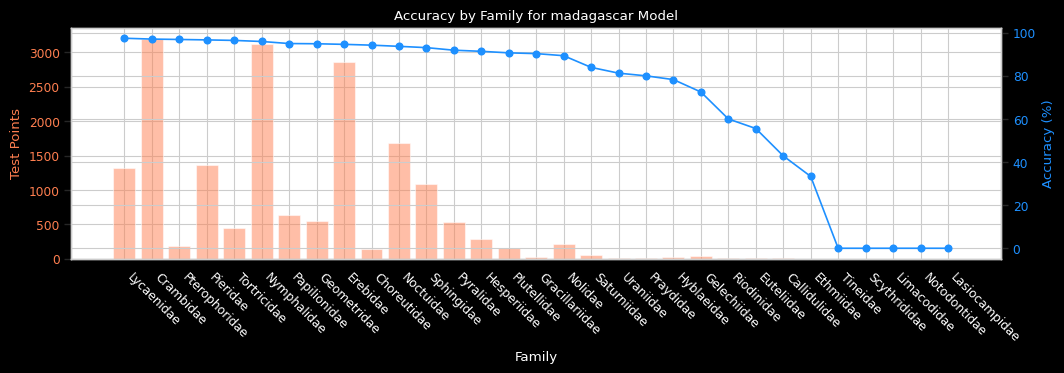

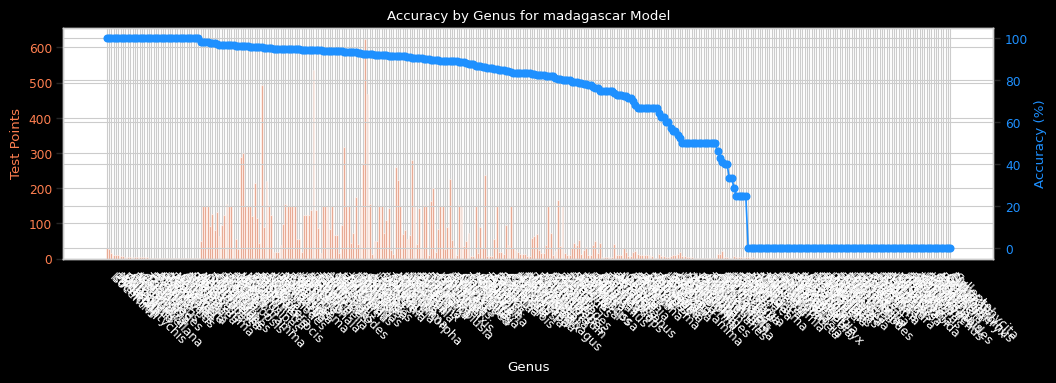

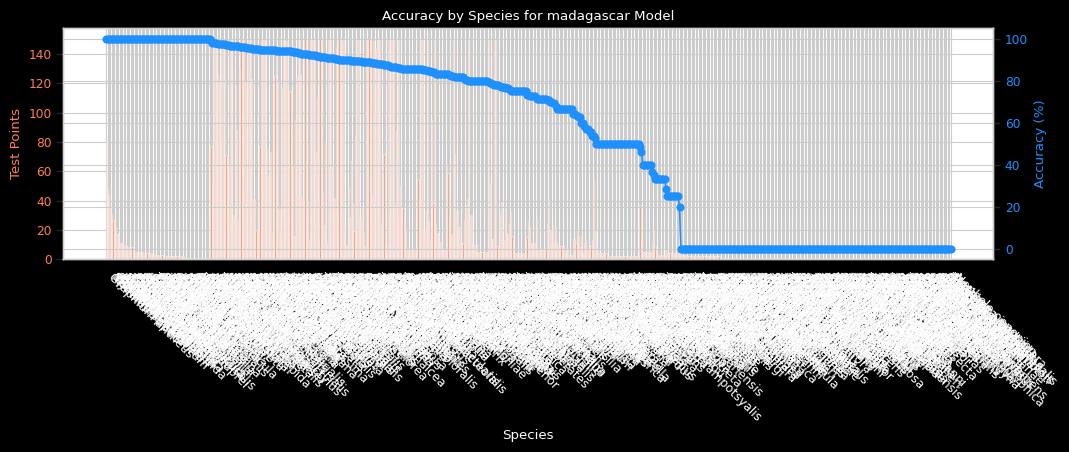

In [71]:
# for family, genus, species plot the accuracy and test points

for r in list(region_df.keys()):
    print('Plotting for ' + r + '...')
    taxon = region_df[r]['taxon']
    for t in ['family', 'genus', 'species']:
        fig, ax1, ax2 = taxon_acc_plot(taxon, taxon=t, region=r, dark_mode=True)
        fig.savefig('/bask/homes/f/fspo1218/amber/projects/compress_existing_models/outputs/plots/taxon/' + r + '_' + t + '_acc.png', dpi=300, bbox_inches='tight', transparent=True)